In [14]:
include("../code/julia/ha-trade-environment.jl")

include("../code/julia/ha-trade-solution.jl") #in here is the ``world_equillibrium'' function

include("../code/julia/ha-trade-helper-functions.jl") #in there is the ``aggregate'' function

include("../code/julia/static-trade-environment.jl")
using MINPACK
using FiniteDifferences
using Plots
using CSV
using DataFrames

Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     3.705262e-01     0.000000e+00        14.669000
Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     3.541550e-01     0.000000e+00        13.241000
     2     9.730270e-02     3.689740e+00       585.670000
     3     2.480789e-02     3.052841e+00        16.948000
     4     1.583219e-02     4.870030e-02        17.760000
     5     9.878220e-03     7.044540e-03        17.252000
     6     7.824319e-03     3.247737e-02        17.846000
     7     2.014406e-03     4.560124e-03        17.629000
     8     1.220889e-03     2.303038e-04        18.066000
     9     1.843255e-03     1.686211e-03        15.681000
    10     7.148686e-04     1.758393e-04        18.450000
    11     4.991935e-04     3.617847e-05        19.915000
    12     4.965180e-05     4.747640e-06        18.058000
    13     3.933743e-05 

In [2]:
Ncntry = 19

dftrade = DataFrame(CSV.File("../code/julia/ek-trade.csv"))

d = reshape(dftrade.d, Ncntry,Ncntry)

df = DataFrame(CSV.File("../code/julia/solution.csv"))

initial_x = [df.wage[2:end]; df.interest_rate]

#initial_x =[df.TFP[2:end]; 1.02*ones(Ncntry)]

TFP = df.TFP
L = df.L

####################################################################################

Ncntry = size(d)[1]

mdl_prm = world_model_params(Ncntry = Ncntry, Na = 100, 
γ = 1.5, ϕ = 2.0, amax = 8.0, σϵ = 0.25, d = d, TFP = TFP, L = L)

@unpack Na, Nshocks, Ncntry, TFP = mdl_prm

world_model_params
  β: Float64 0.95
  γ: Float64 1.5
  ϕ: Float64 2.0
  amax: Float64 8.0
  Ncntry: Int64 19
  σϵ: Float64 0.25
  Na: Int64 100
  agrid: Array{Float64}((100,)) [-2.0, -1.898989898989899, -1.797979797979798, -1.696969696969697, -1.595959595959596, -1.494949494949495, -1.393939393939394, -1.292929292929293, -1.1919191919191918, -1.0909090909090908  …  7.090909090909091, 7.191919191919192, 7.292929292929293, 7.393939393939394, 7.494949494949495, 7.595959595959596, 7.696969696969697, 7.797979797979798, 7.898989898989899, 8.0]
  Nar: Int64 5
  Nma: Int64 2
  Nshocks: Int64 10
  statesize: Int64 19000
  ρ: Float64 0.9
  σar: Float64 0.19748417658131498
  σma: Float64 0.22847319317591724
  mc: MarkovChain{Float64, Matrix{Float64}, Vector{Float64}}
  TFP: Array{Float64}((19,)) [0.7529232265121797, 0.7157410137531597, 0.6566585956765728, 0.8108043530116216, 0.7286880721516208, 0.7806205144298515, 0.8717047221225422, 0.9231978733522944, 0.5791797155010584, 0.8554358755934058, 0.

In [3]:
f(x) = world_equillibrium(x, mdl_prm, hh_solution_method = "itteration", stdist_sol_method = "itteration");

function f!(fvec, x)

    fvec .= f(x)

end

###################################################################

n = length(initial_x)
diag_adjust = n - 1

sol = fsolve(f!, initial_x, show_trace = true, method = :hybr;
      ml=diag_adjust, mu=diag_adjust,
      diag=ones(n),
      mode= 1,
      tol=1e-5,
       )

print(sol)

###################################################################

Wsol = [1.0; sol.x[1:Ncntry-1]]
Rsol = sol.x[Ncntry:end]

Y, tradeflows, A_demand, tradeshare, hh, dist = world_equillibrium(Rsol,
    Wsol, mdl_prm, hh_solution_method = "itteration");

Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     5.720199e-08     0.000000e+00        67.753000
     2     8.526010e-14     2.962843e-13       654.798000
Results of Nonlinear Solver Algorithm
 * Algorithm: Modified Powell
 * Starting Point: [0.8154054425531905, 1.0814010323108787, 1.1981721488697155, 0.9708966855655254, 0.9103090389436599, 0.9707582356444822, 1.4197483455403428, 0.6203652966133649, 0.936555329682745, 1.1331094664668477, 1.0591975047695688, 1.0285350470633403, 0.9645537812388933, 0.6978725467763967, 0.7538695624971913, 1.0668760057485984, 1.0355333967618001, 1.2277004890899204, 1.0246652489617645, 1.0284512639640753, 1.0239268412528502, 1.021397759394577, 1.02631182851171, 1.0269485731380972, 1.0261668560399146, 1.0197600824999011, 1.031456138780066, 1.0264403651086895, 1.022468043679725, 1.0246005403347591, 1.0244807033267334, 1.0263507305598263, 1.0302590663161872, 1.0291605196471596, 1.024945015

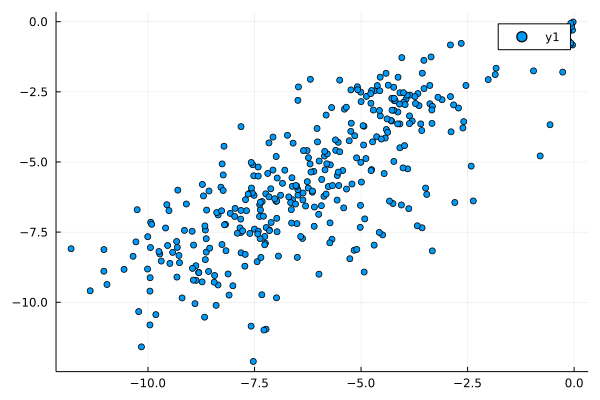

In [4]:
plot(log.(vec(tradeshare)), log.(dftrade.tradesharedata), seriestype = :scatter)

In [10]:
d_prime =  1.0 .+ (d .- 1.0).*0.99

Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     1.273591e-03     0.000000e+00        17.290000
     2     3.052342e-06     1.345756e-05       670.134000
     3     1.162948e-08     2.036787e-10        17.929000
Results of Nonlinear Solver Algorithm
 * Algorithm: Modified Powell
 * Starting Point: [0.8154054425531905, 1.0814010323108787, 1.1981721488697155, 0.9708966855655254, 0.9103090389436599, 0.9707582356444822, 1.4197483455403428, 0.6203652966133649, 0.936555329682745, 1.1331094664668477, 1.0591975047695688, 1.0285350470633403, 0.9645537812388933, 0.6978725467763967, 0.7538695624971913, 1.0668760057485984, 1.0355333967618001, 1.2277004890899204, 1.0246652489617645, 1.0284512639640753, 1.0239268412528502, 1.021397759394577, 1.02631182851171, 1.0269485731380972, 1.0261668560399146, 1.0197600824999011, 1.031456138780066, 1.0264403651086895, 1.022468043679725, 1.0246005403347591, 1.0244807033267334, 1.02635073055

19×19 Matrix{Float64}:
 1.0      7.78819  4.0488   3.96783  …  7.24234  5.24559  4.13981  2.55262
 4.50922  1.0      1.89677  3.54761     3.66363  2.65491  2.09629  2.28266
 4.50922  3.64367  1.0      3.54761     3.66363  2.65491  1.64529  2.28266
 4.50922  6.96234  3.61998  1.0         6.47444  4.6897   3.70132  1.07498
 4.50922  3.64367  1.89677  3.54761     3.66363  2.08315  1.93929  2.28266
 4.50922  3.93938  2.05032  3.54761  …  3.88306  1.86875  2.09629  2.28266
 4.50922  3.64367  1.44386  3.54761     3.03926  2.65491  1.64529  2.28266
 4.50922  2.77143  1.70165  3.54761     3.66363  2.45586  1.93929  2.28266
 4.50922  3.93938  2.05032  3.54761     3.66363  2.65491  2.09629  2.28266
 4.50922  3.26789  1.89677  3.54761     3.66363  2.65491  2.09629  2.28266
 4.03152  6.96234  3.61998  3.96783  …  7.24234  4.6897   3.70132  2.55262
 4.50922  3.64367  1.44386  3.54761     3.66363  2.45586  1.64529  2.28266
 2.28292  7.78819  4.0488   3.96783     7.24234  5.24559  4.13981  2.55262
 4

In [15]:
mdl_prm = world_model_params(Ncntry = Ncntry, Na = 100, 
γ = 1.5, ϕ = 2.0, amax = 8.0, σϵ = 0.25, d = d_prime, TFP = TFP, L = L)

f(x) = world_equillibrium(exp.(x), mdl_prm, hh_solution_method = "itteration", stdist_sol_method = "itteration");

function f!(fvec, x)

    fvec .= f(x)

end

initial_x =[ones(Ncntry-1); 1.02*ones(Ncntry)]

###################################################################

n = length(initial_x)
diag_adjust = n - 1

sol = fsolve(f!, log.(initial_x), show_trace = true, method = :hybr;
      ml=diag_adjust, mu=diag_adjust,
      diag=ones(n),
      mode= 1,
      tol=1e-5,
       )

print(sol)

###################################################################

Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     3.541550e-01     0.000000e+00        18.764000
     2     2.248305e-01     3.689731e+00       615.271000
     3     2.246752e-02     3.120420e+00        20.031000
     4     1.232252e-02     3.091069e-02        17.801000
     5     6.360860e-03     1.769080e-02        19.370000
     6     3.087983e-03     3.371022e-03        18.023000
     7     3.998810e-03     3.246782e-03        18.695000
     8     5.722195e-03     1.256195e-02        18.926000
     9     1.319115e-04     1.508407e-03       706.384000
    10     1.841843e-05     1.581707e-04        18.231000
    11     3.228198e-06     4.901473e-06        16.771000
    12     2.770794e-07     1.937638e-09        20.186000
    13     4.021829e-09     1.905026e-11        19.532000
    14     4.781177e-10     2.608936e-14        19.860000
Results of Nonlinear Solver Algorithm
 * Algorithm: Modified Powell
 * Starti

In [16]:
Wsol = exp.([0.0; sol.x[1:Ncntry-1]])
Rsol = exp.(sol.x[Ncntry:end])

Y, tradeflows, A_demand, tradeshare, hh, dist = world_equillibrium(Rsol,
    Wsol, mdl_prm, hh_solution_method = "itteration");

In [17]:
Rsol

19-element Vector{Float64}:
 1.0246777814548835
 1.0284515157784568
 1.0239065978047295
 1.0213900373922478
 1.0263051072687208
 1.0269498054992705
 1.0261704022531848
 1.0197209183696214
 1.0314562917360948
 1.0264503131476204
 1.0224875610419224
 1.024586316704509
 1.0244905175155663
 1.0263476692631879
 1.0302652079905303
 1.0291647724811483
 1.0249470939230247
 1.0252473512034652
 1.0214914788314482

In [167]:
welfare = 100.0 .*(log_sum_column(hh[1].Tv, mdl_prm.σϵ) - log_sum_column(hhp[1].Tv, mdl_prm.σϵ))./ log_sum_column(hh[1].Tv, mdl_prm.σϵ)  

100×5 Matrix{Float64}:
 0.144972  0.282196  0.571888  1.0099   1.5557
 0.151688  0.291972  0.581249  1.0176   1.56321
 0.157932  0.300513  0.58871   1.0257   1.5707
 0.163934  0.308416  0.596864  1.03365  1.57818
 0.170117  0.315931  0.604891  1.04159  1.58564
 0.175997  0.323243  0.612978  1.0495   1.59309
 0.181731  0.330447  0.621043  1.05744  1.60051
 0.187398  0.338015  0.628992  1.06536  1.60792
 0.19304   0.345432  0.636891  1.07325  1.61532
 0.198692  0.352763  0.644756  1.08112  1.6227
 0.204355  0.360062  0.652618  1.08902  1.6301
 0.209999  0.367282  0.66049   1.09689  1.63748
 0.215668  0.374475  0.66834   1.10474  1.64484
 ⋮                                      
 0.726301  0.933067  1.24847   1.67471  2.13326
 0.73361   0.94047   1.25591   1.68181  2.13752
 0.740921  0.947873  1.26334   1.68886  2.14186
 0.748179  0.955289  1.27077   1.69588  2.14649
 0.755419  0.962735  1.27819   1.70286  2.15103
 0.76266   0.970177  1.2856    1.70978  2.15547
 0.76995   0.977617  1.29302

In [169]:
((.77 / .806).^-.25 - 1)*100

1.1488802037870727

In [168]:
100*(sum( vec(log_sum_column(hh[1].Tv, mdl_prm.σϵ)).* dist[1].λ ) 
    - sum( vec(log_sum_column(hhp[1].Tv, mdl_prm.σϵ)).* distp[1].λ )) / sum( vec(log_sum_column(hhp[1].Tv, mdl_prm.σϵ)).* distp[1].λ )

0.7122465317983306

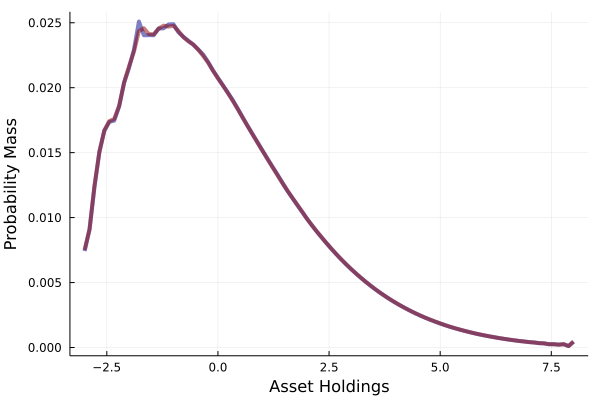

In [47]:
adist = get_distribution(dist[1].state_index, dist[1].λ);

plot(mdl_prm.agrid, adist, alpha = 0.5, lw = 4,
    color = "dark blue", ylabel = "Probability Mass", xlabel = "Asset Holdings", label = false)

adistp = get_distribution(dist[1].state_index, distp[1].λ);

plot!(mdl_prm.agrid, adistp, alpha = 0.5, lw = 4,
    color = "dark red", ylabel = "Probability Mass", xlabel = "Asset Holdings", label = false)

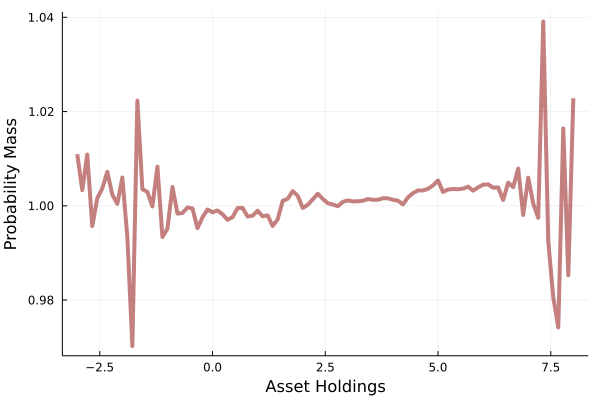

In [48]:
plot(mdl_prm.agrid, adistp./adist, alpha = 0.5, lw = 4,
    color = "dark red", ylabel = "Probability Mass", xlabel = "Asset Holdings", label = false)